In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from ugradiolab.analysis import SpectrumLite


def psd_without_dc(spec):
    vals = np.array(spec.psd, dtype=float, copy=True)
    i0 = spec.bin_at(spec.center_freq)
    lo = max(0, i0)
    hi = min(vals.size, i0 + 1)
    vals[lo:hi] = np.nan
    return vals


/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
def load_or_process(data_dir: Path, exclude_fn=None) -> list[SpectrumLite]:
    """Load pre-processed SpectrumLite .npz files if available, else compute from raw Records.

    Processed files are cached in a sibling ``<dir>_lite/`` directory so that
    subsequent runs skip the (potentially expensive) FFT step.

    Parameters
    ----------
    data_dir : Path
        Directory containing raw Record .npz files.
    exclude_fn : callable, optional
        Paths for which ``exclude_fn(path)`` is True are skipped during processing.
    """
    lite_dir = data_dir.parent / (data_dir.name + '_lite')
    if lite_dir.exists() and any(lite_dir.glob('*.npz')):
        print(f'Loading pre-processed SpectrumLite from {lite_dir}')
        return [SpectrumLite.load(p) for p in sorted(lite_dir.glob('*.npz'))]
    print(f'Processing raw data from {data_dir} → {lite_dir}')
    lite_dir.mkdir(exist_ok=True)
    spectra = []
    for p in sorted(data_dir.glob('*.npz')):
        if exclude_fn is not None and exclude_fn(p):
            continue
        sl = SpectrumLite.from_data(p)
        sl.save(lite_dir / p.name)
        spectra.append(sl)
    return spectra


In [3]:
DATA_DIR = Path('../../data/lab02/noise')

obs_spectra_raw = load_or_process(DATA_DIR)
obs_spectra_raw.sort(key=lambda s: s.nblocks)
obs_spectra = [(s.nblocks, s) for s in obs_spectra_raw]

for n, spec in obs_spectra:
    print(f'  nblocks={n:>5d}  total_power={spec.total_power:.4f}')

Loading pre-processed SpectrumLite from ../../data/lab_2_1_noise_lite
  nblocks=    2  total_power=26.2846
  nblocks=    4  total_power=26.7110
  nblocks=    8  total_power=28.3048
  nblocks=   16  total_power=30.3308
  nblocks=   32  total_power=31.2703
  nblocks=   64  total_power=31.6592
  nblocks=  128  total_power=31.7838
  nblocks=  256  total_power=31.8226
  nblocks=  512  total_power=31.8113
  nblocks= 1024  total_power=31.5662
  nblocks= 2048  total_power=31.2793
  nblocks= 4096  total_power=30.4895


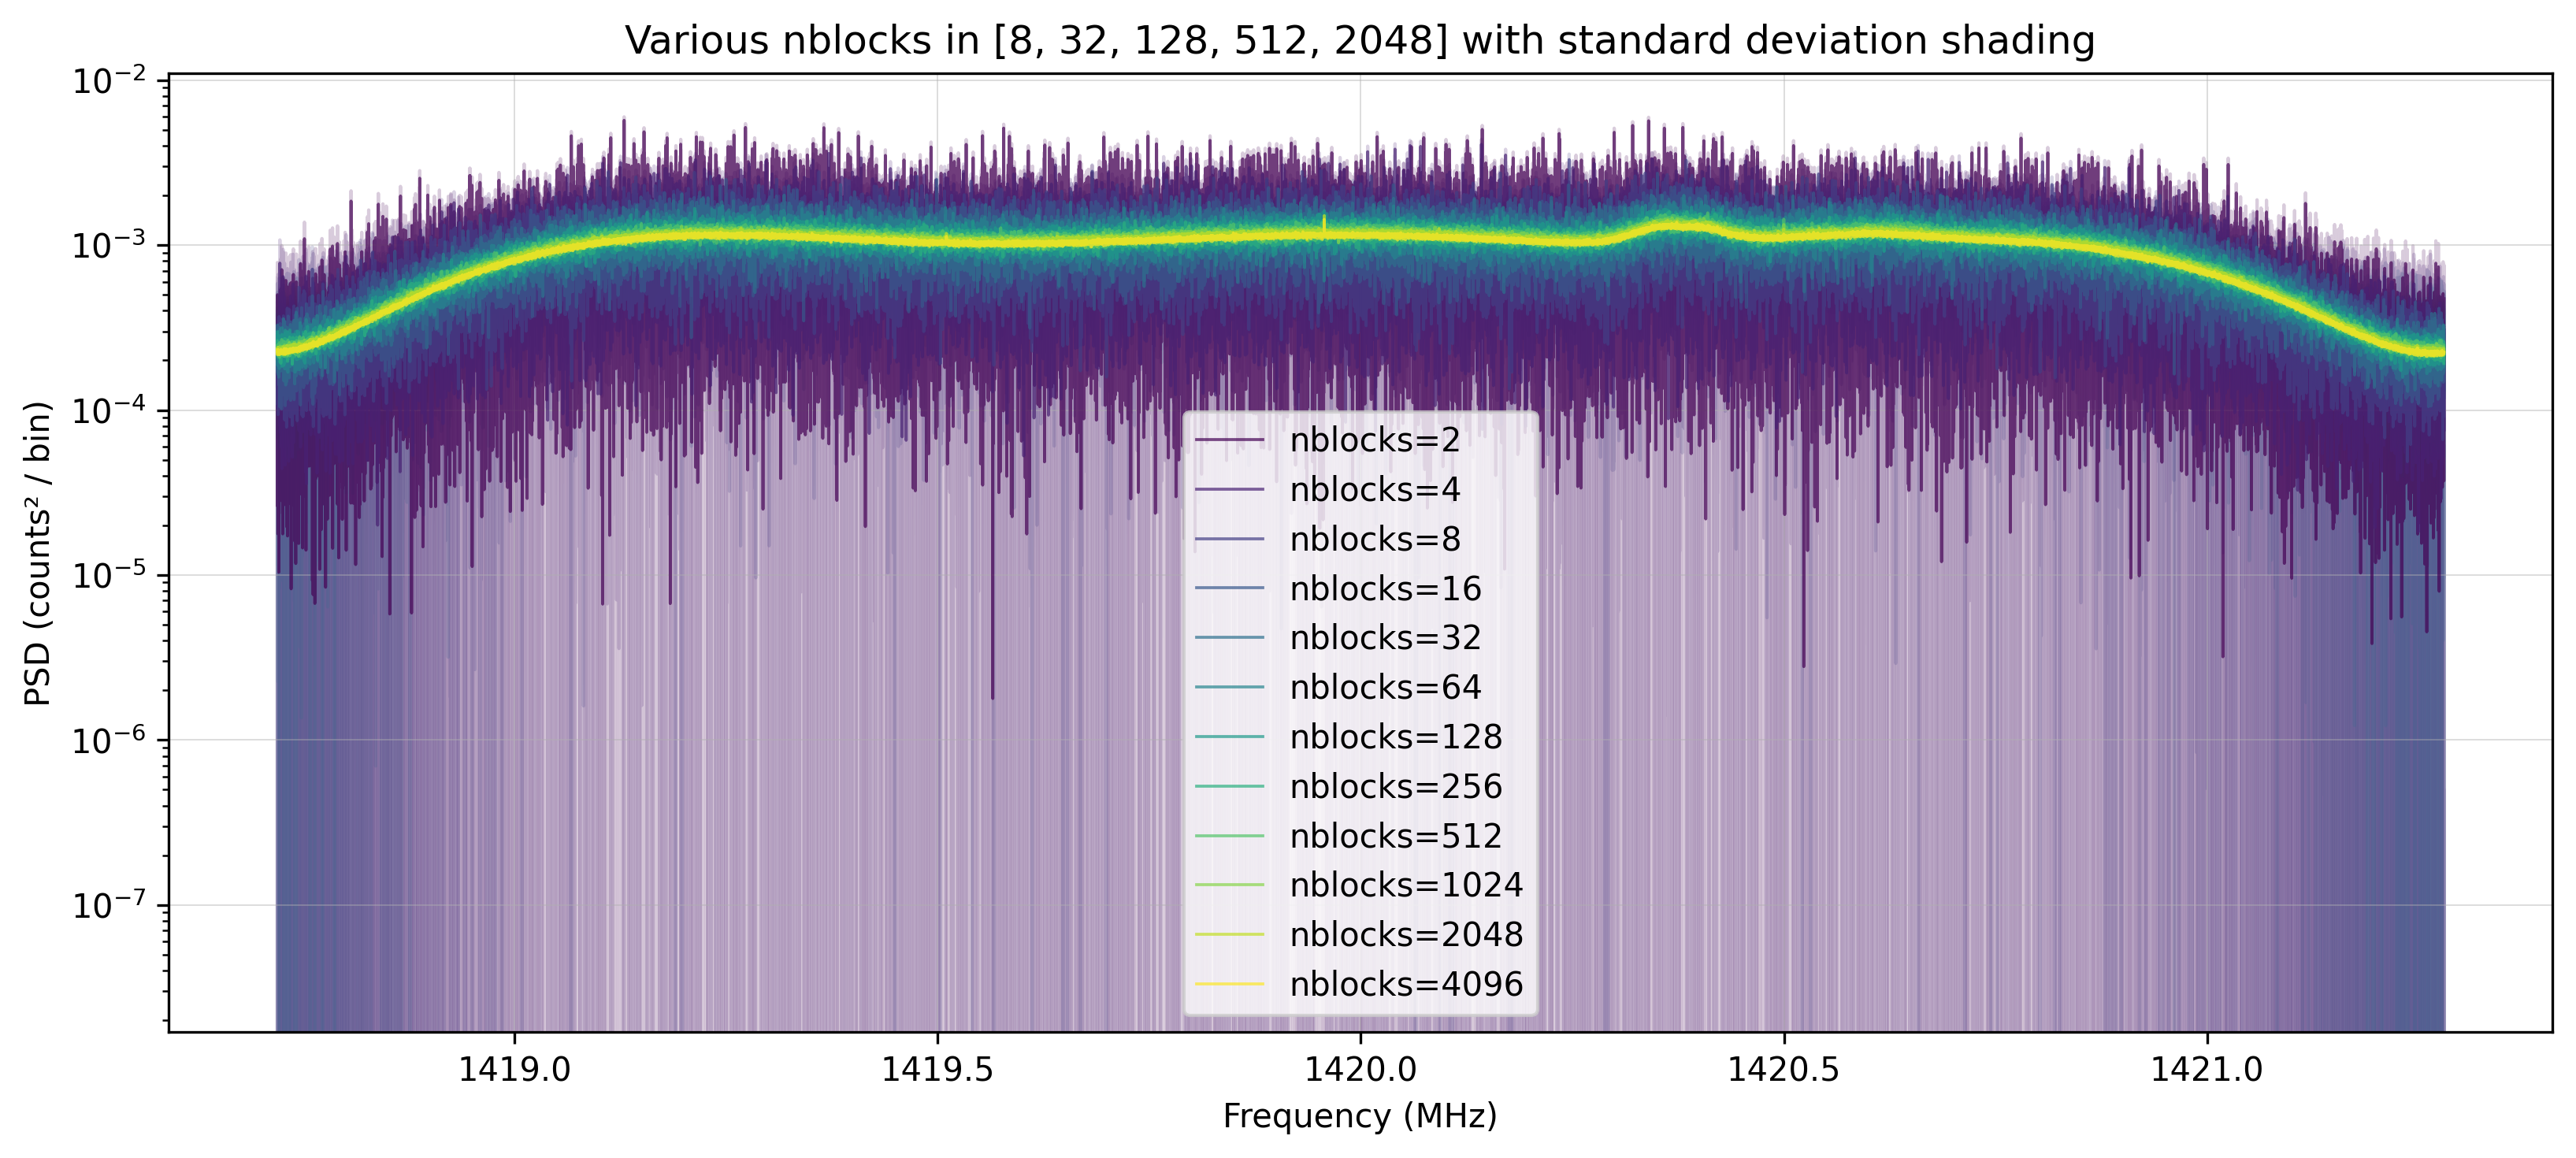

In [4]:
cmap = plt.colormaps['viridis']
colors = [cmap(i / max(len(obs_spectra) - 1, 1)) for i in range(len(obs_spectra))]

fig, ax = plt.subplots(figsize=(11, 5), dpi=300)

for (n, spec), color in zip(obs_spectra, colors):
    psd = psd_without_dc(spec)
    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std,
                    color=color, alpha=0.2)
    ax.semilogy(spec.freqs_mhz, psd, color=color, lw=0.9, alpha=0.7, label=f'nblocks={n}')

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts² / bin)')
ax.set_title('Various nblocks in [8, 32, 128, 512, 2048] with standard deviation shading')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()


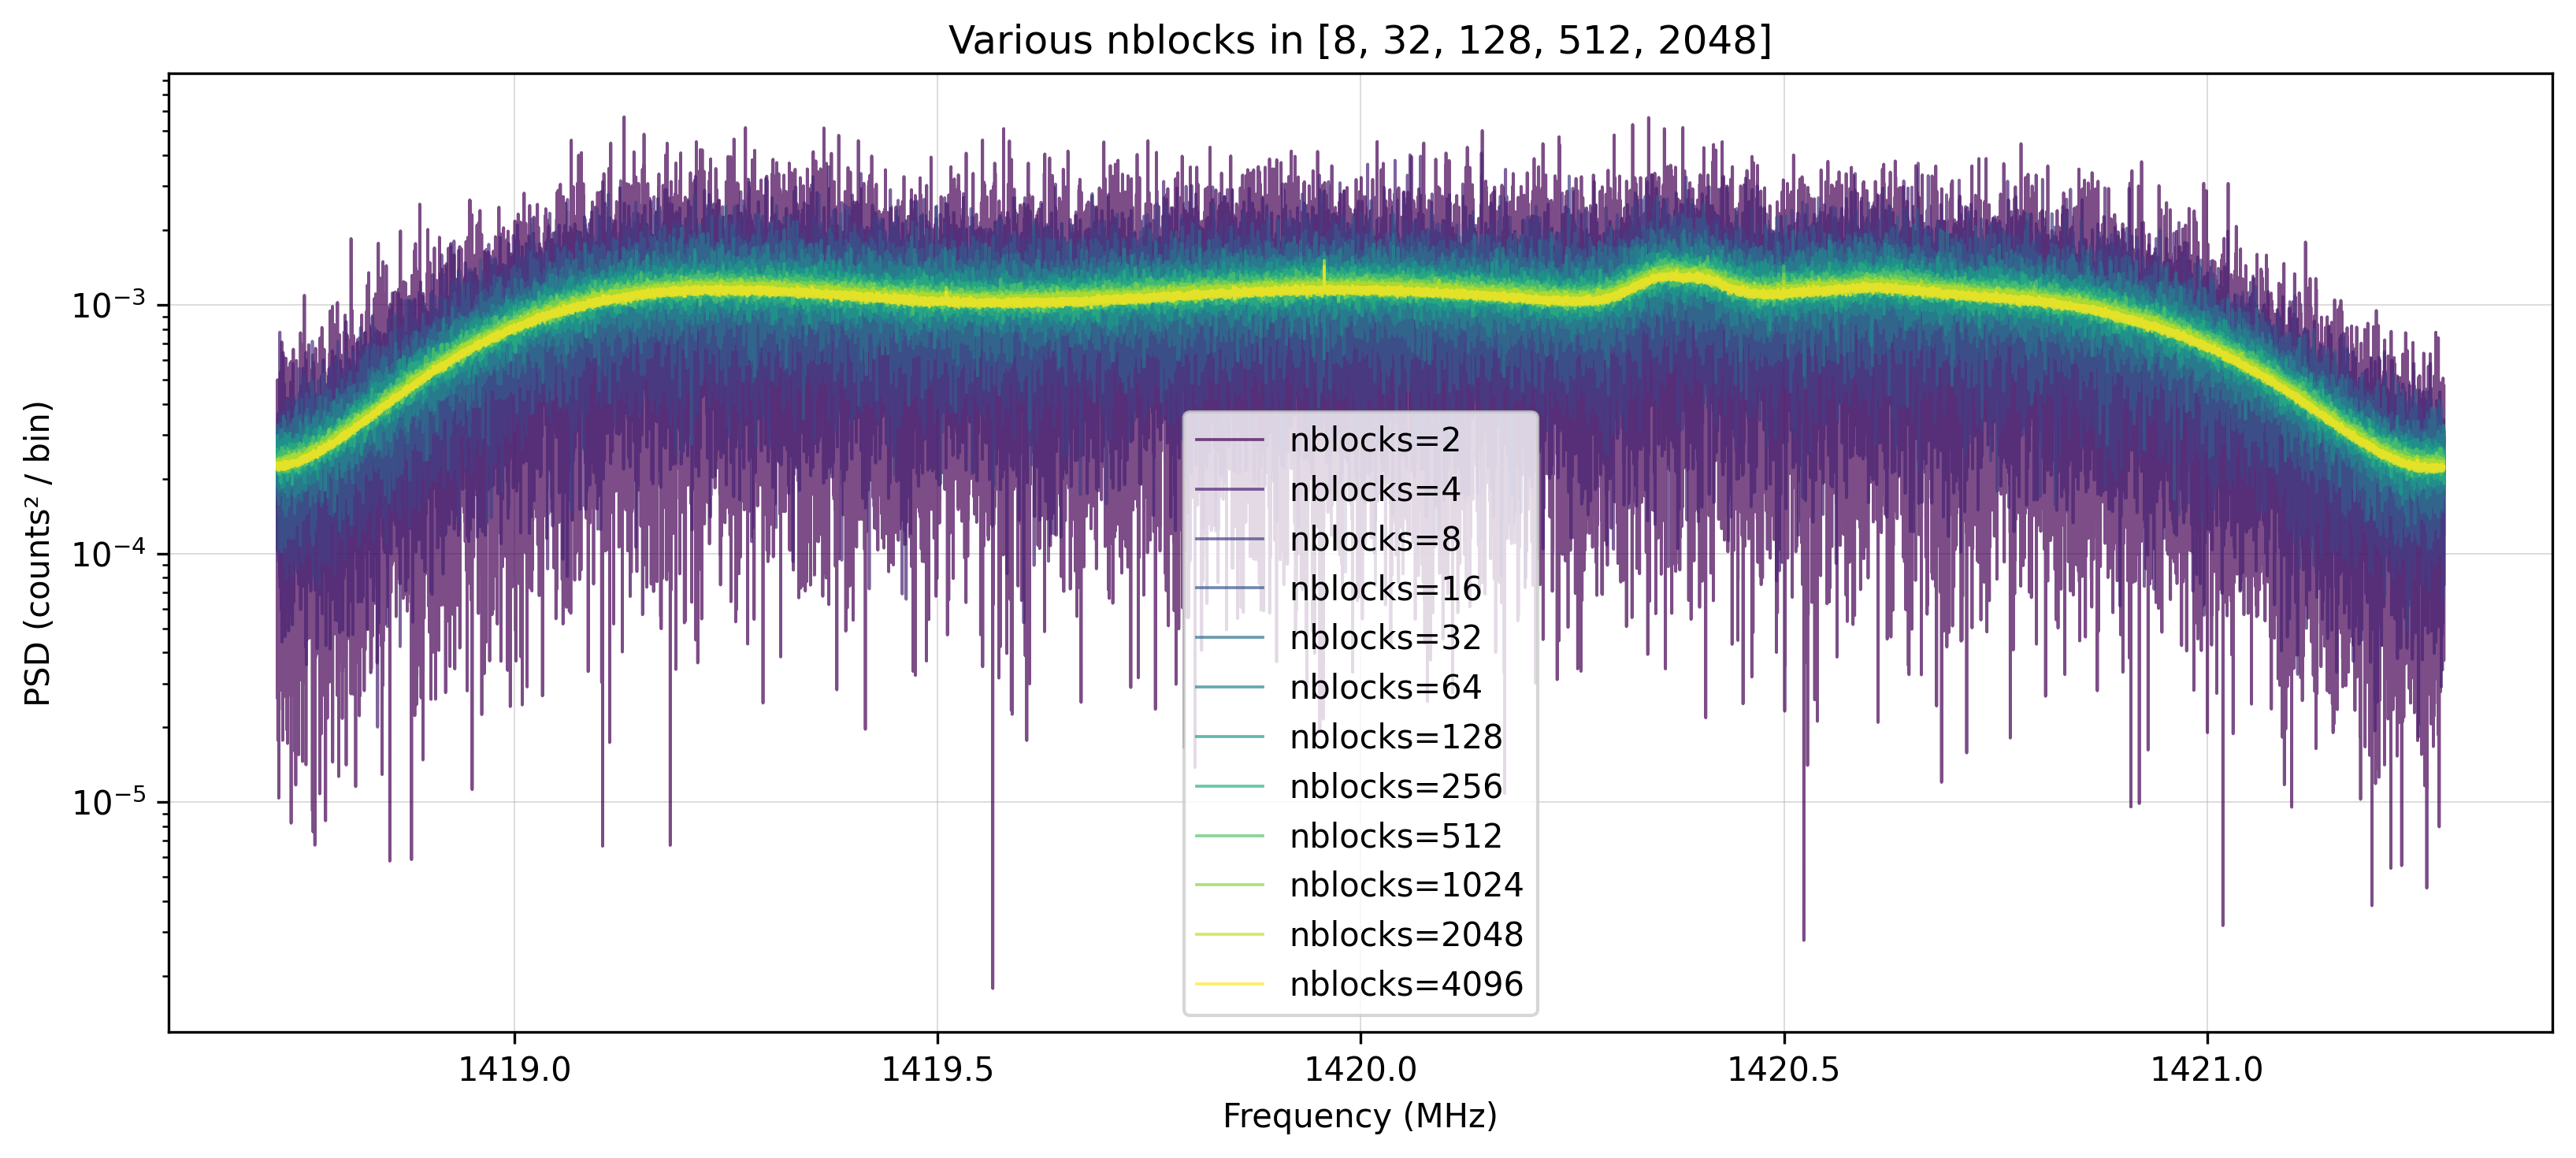

In [5]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=300)

for (n, spec), color in zip(obs_spectra, colors):
    psd = psd_without_dc(spec)
    ax.semilogy(spec.freqs_mhz, psd, color=color, lw=0.9, alpha=0.7, label=f'nblocks={n}')

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts² / bin)')
ax.set_title('Various nblocks in [8, 32, 128, 512, 2048]')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()


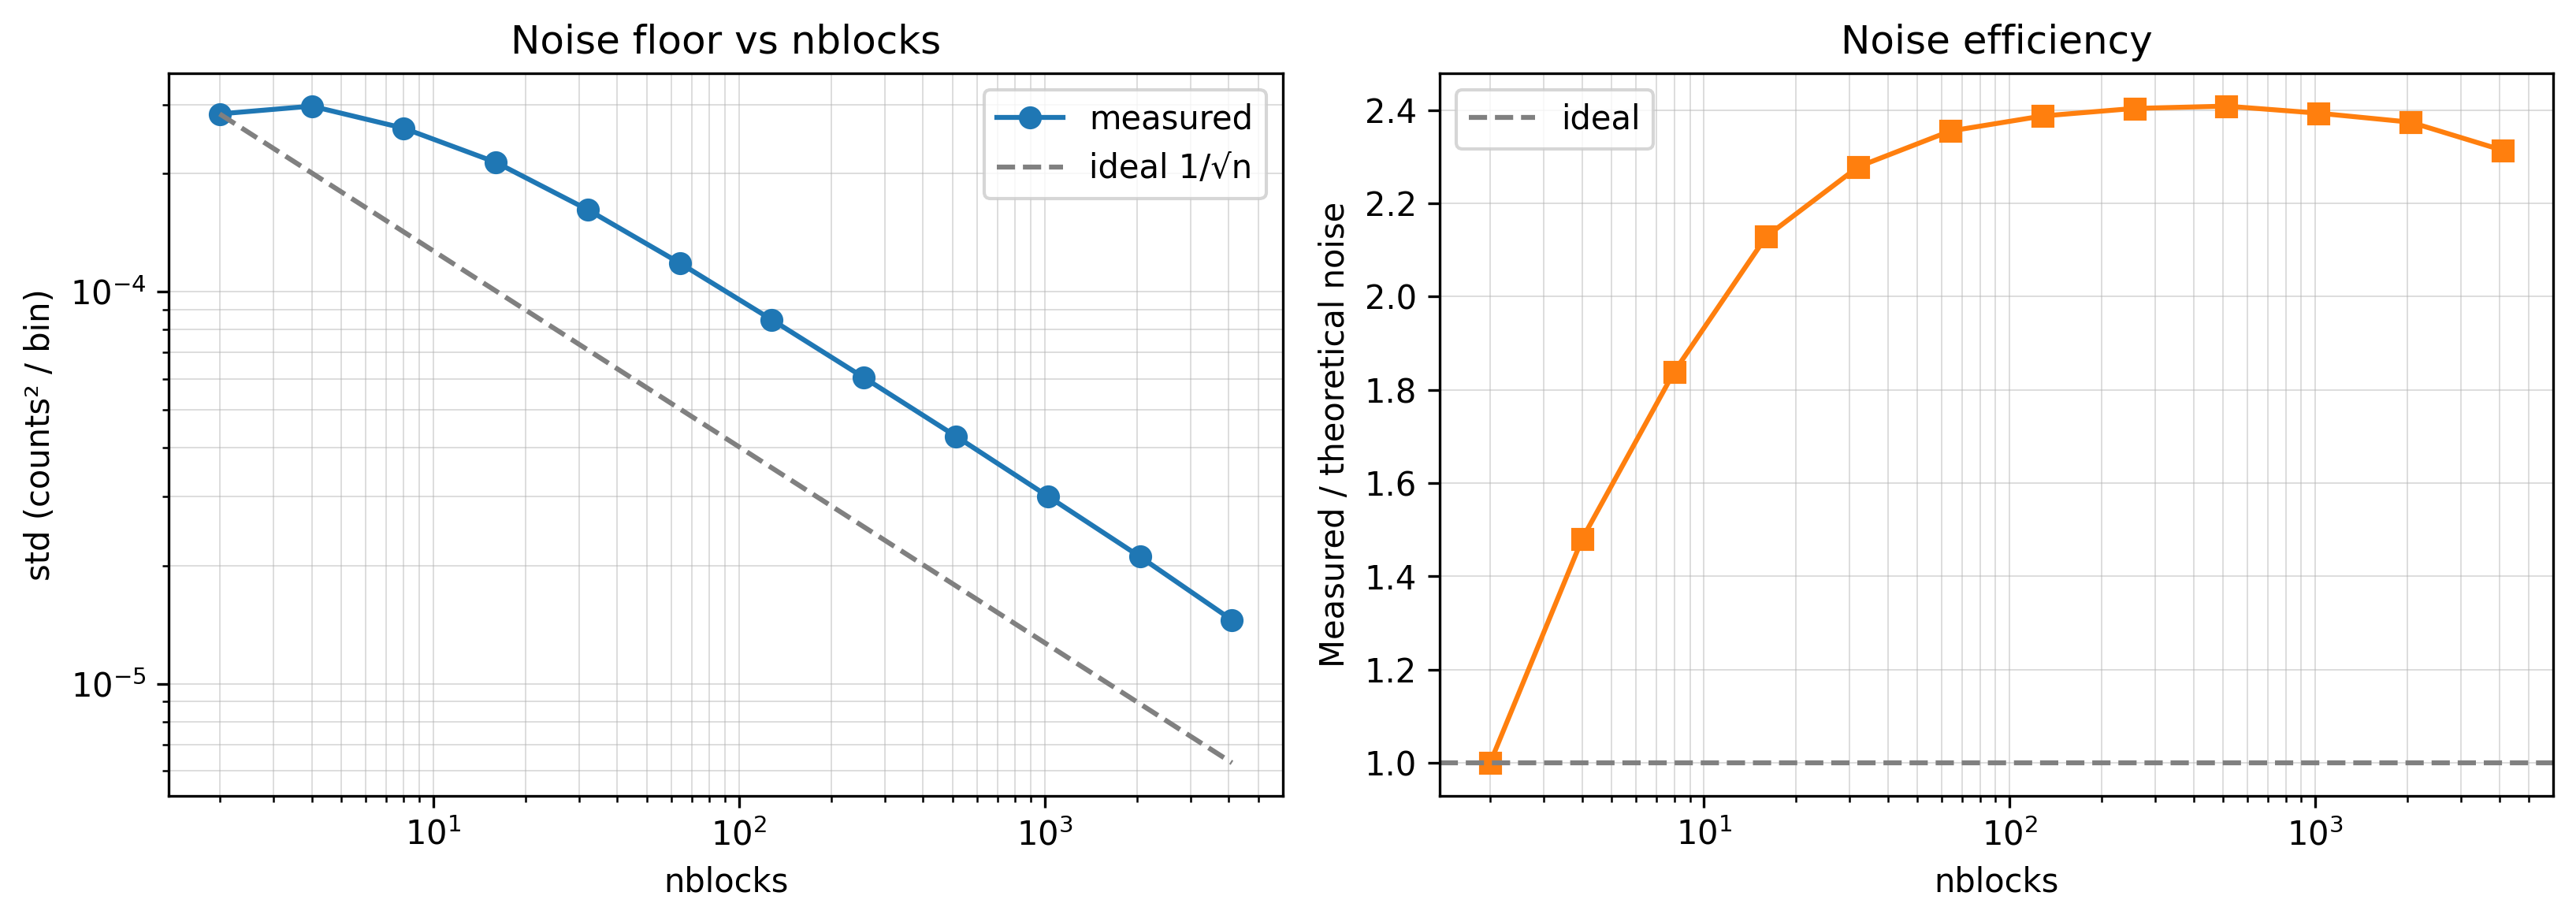

  nblocks=    2  noise=0.00028  efficiency=1.000
  nblocks=    4  noise=0.00030  efficiency=1.480
  nblocks=    8  noise=0.00026  efficiency=1.839
  nblocks=   16  noise=0.00021  efficiency=2.129
  nblocks=   32  noise=0.00016  efficiency=2.278
  nblocks=   64  noise=0.00012  efficiency=2.355
  nblocks=  128  noise=0.00008  efficiency=2.387
  nblocks=  256  noise=0.00006  efficiency=2.403
  nblocks=  512  noise=0.00004  efficiency=2.408
  nblocks= 1024  noise=0.00003  efficiency=2.393
  nblocks= 2048  noise=0.00002  efficiency=2.374
  nblocks= 4096  noise=0.00001  efficiency=2.314


In [6]:
ns    = np.array([n for n, _ in obs_spectra])
noise = np.array([spec.std for _, spec in obs_spectra])

theoretical = noise[0] / np.sqrt(ns / ns[0])
efficiency  = noise / theoretical

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), dpi=300)

ax1.loglog(ns, noise,       'o-', label='measured')
ax1.loglog(ns, theoretical, '--', color='gray', label='ideal 1/√n')
ax1.set_xlabel('nblocks')
ax1.set_ylabel('std (counts² / bin)')
ax1.set_title('Noise floor vs nblocks')
ax1.legend()
ax1.grid(True, which='both', lw=0.4, alpha=0.5)

ax2.semilogx(ns, efficiency, 's-', color='C1')
ax2.axhline(1.0, color='gray', linestyle='--', label='ideal')
ax2.set_xlabel('nblocks')
ax2.set_ylabel('Measured / theoretical noise')
ax2.set_title('Noise efficiency')
ax2.legend()
ax2.grid(True, which='both', lw=0.4, alpha=0.5)

fig.tight_layout()
plt.show()

for n, s, e in zip(ns, noise, efficiency):
    print(f'  nblocks={n:>5d}  noise={s:.5f}  efficiency={e:.3f}')

In [7]:
LONG_DIR = Path('../../data/lab02/standard_combined')

long_spectra = load_or_process(LONG_DIR)
long_spectra.sort(key=lambda s: s.center_freq)

for spec in long_spectra:
    print(f'  LO={spec.center_freq/1e6:.0f} MHz  nblocks={spec.nblocks}  total_power={spec.total_power:.4f}')

Loading pre-processed SpectrumLite from ../../data/lab_2_1_long_combined_lite
  LO=1420 MHz  nblocks=16384  total_power=29.7938
  LO=1421 MHz  nblocks=16384  total_power=28.1853


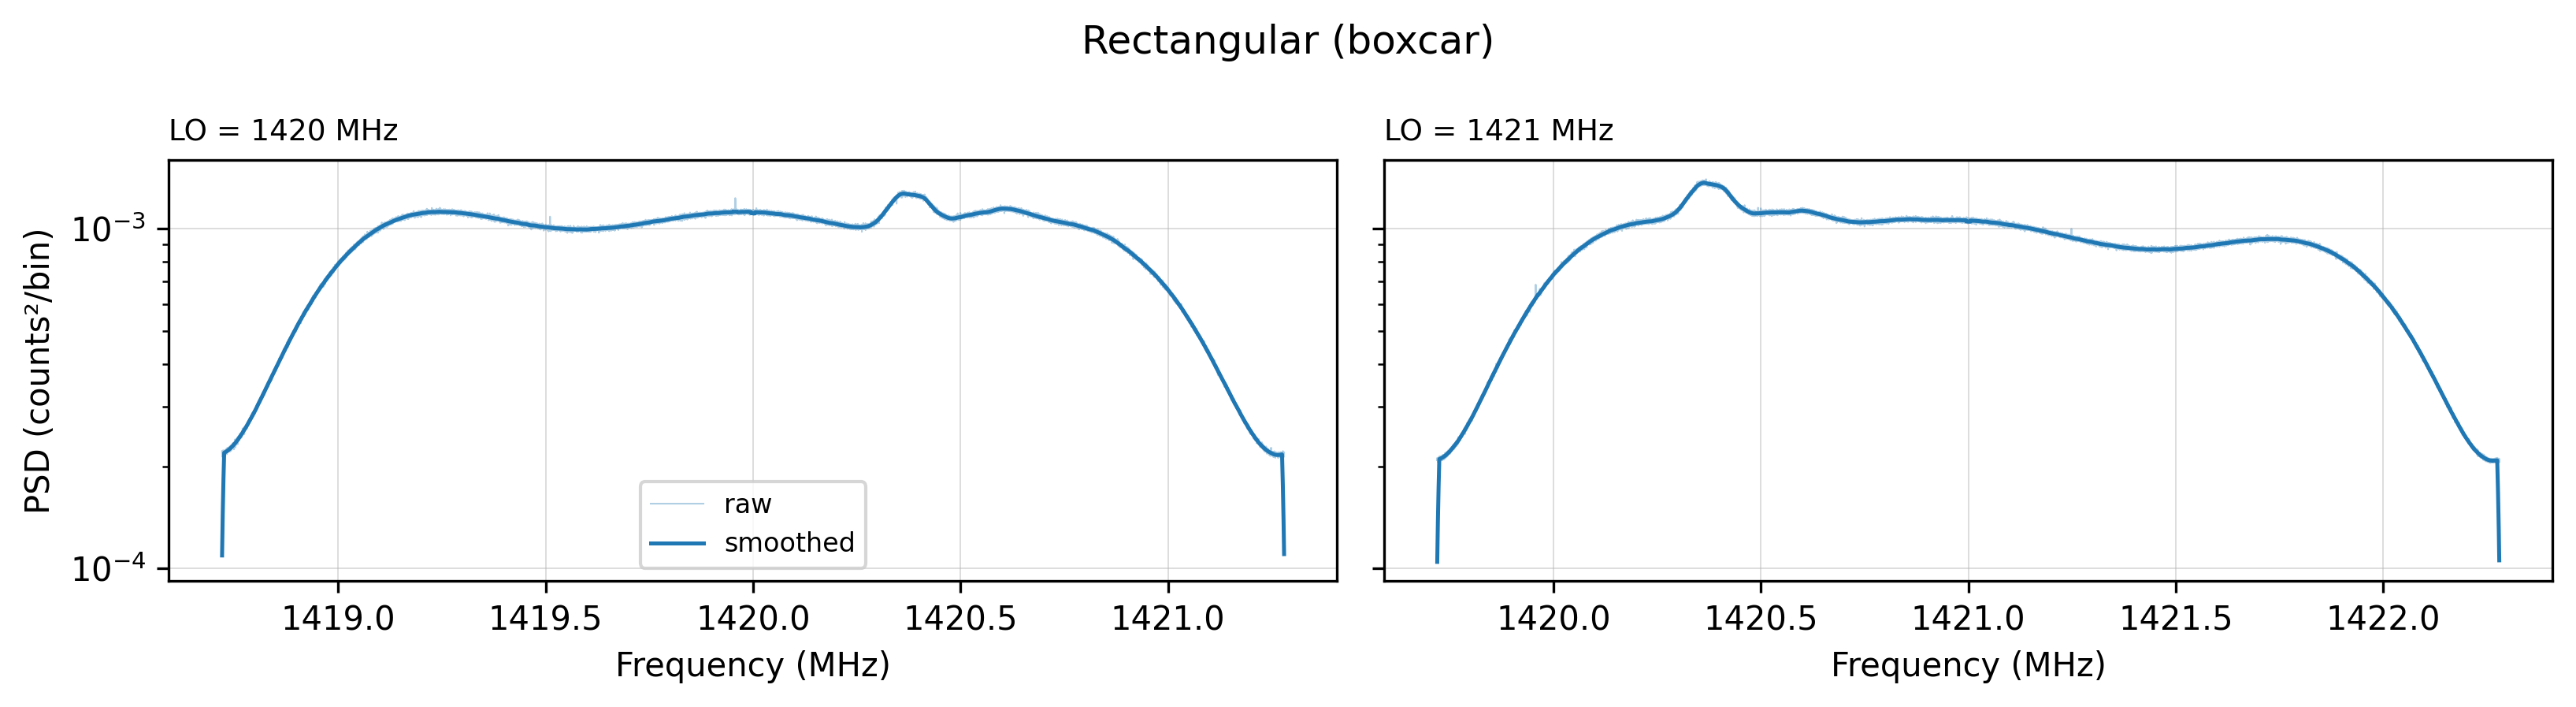

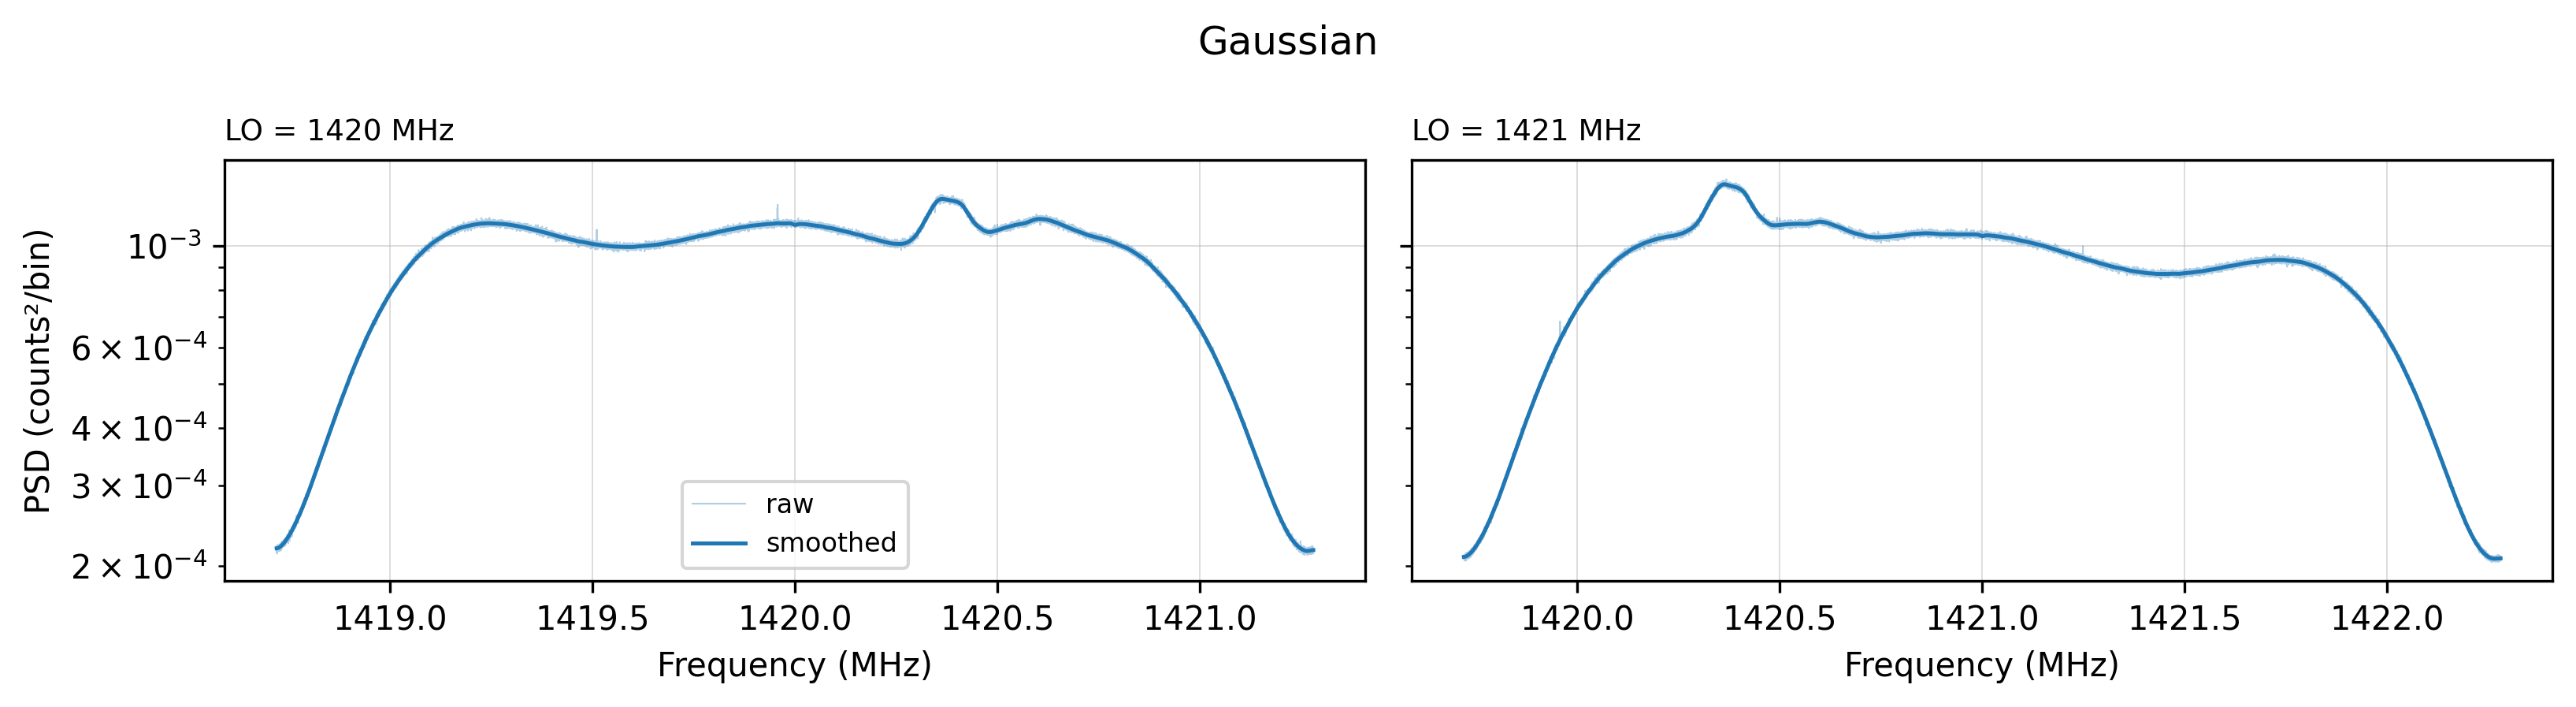

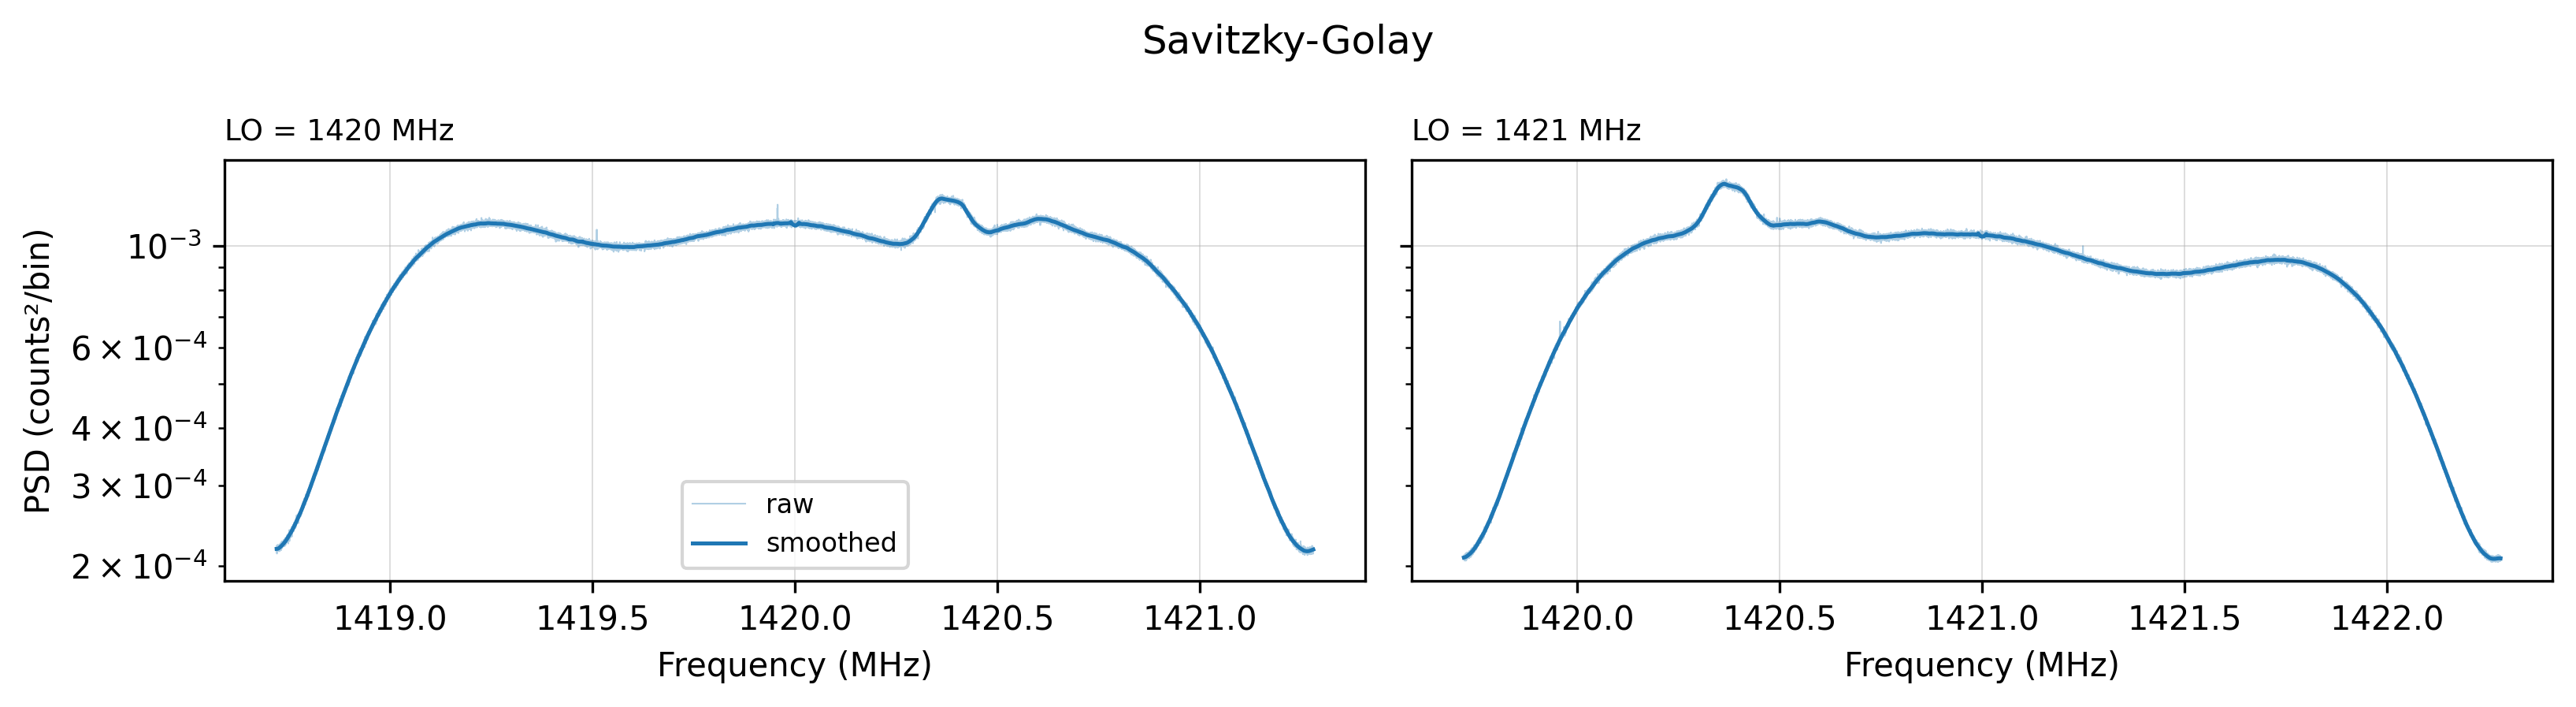

In [8]:
spec_1420 = next(s for s in long_spectra if abs(s.center_freq - 1420e6) < 0.5e6)
spec_1421 = next(s for s in long_spectra if abs(s.center_freq - 1421e6) < 0.5e6)

smoothing_methods = [
    ('Rectangular (boxcar)',  dict(method='boxcar',   M=128)),
    ('Gaussian',              dict(method='gaussian', sigma=64)),
    ('Savitzky-Golay',        dict(method='savgol',   window_length=257, polyorder=3)),
]

for title, kwargs in smoothing_methods:
    fig, axes = plt.subplots(1, 2, figsize=(11, 3), dpi=300, sharey=True)
    for ax, spec, label in zip(axes, [spec_1420, spec_1421], ['1420 MHz', '1421 MHz']):
        psd_raw = psd_without_dc(spec)
        psd_smooth = spec.smooth(**kwargs)

        ax.semilogy(spec.freqs_mhz, psd_raw,    color='C0', lw=0.5, alpha=0.35, label='raw')
        ax.semilogy(spec.freqs_mhz, psd_smooth, color='C0', lw=1.2,             label='smoothed')
        ax.set_title(f'LO = {label}', fontsize=9, loc='left')
        ax.set_xlabel('Frequency (MHz)')
        ax.grid(True, lw=0.4, alpha=0.5)

    axes[0].set_ylabel('PSD (counts²/bin)')
    axes[0].legend(fontsize=8)
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


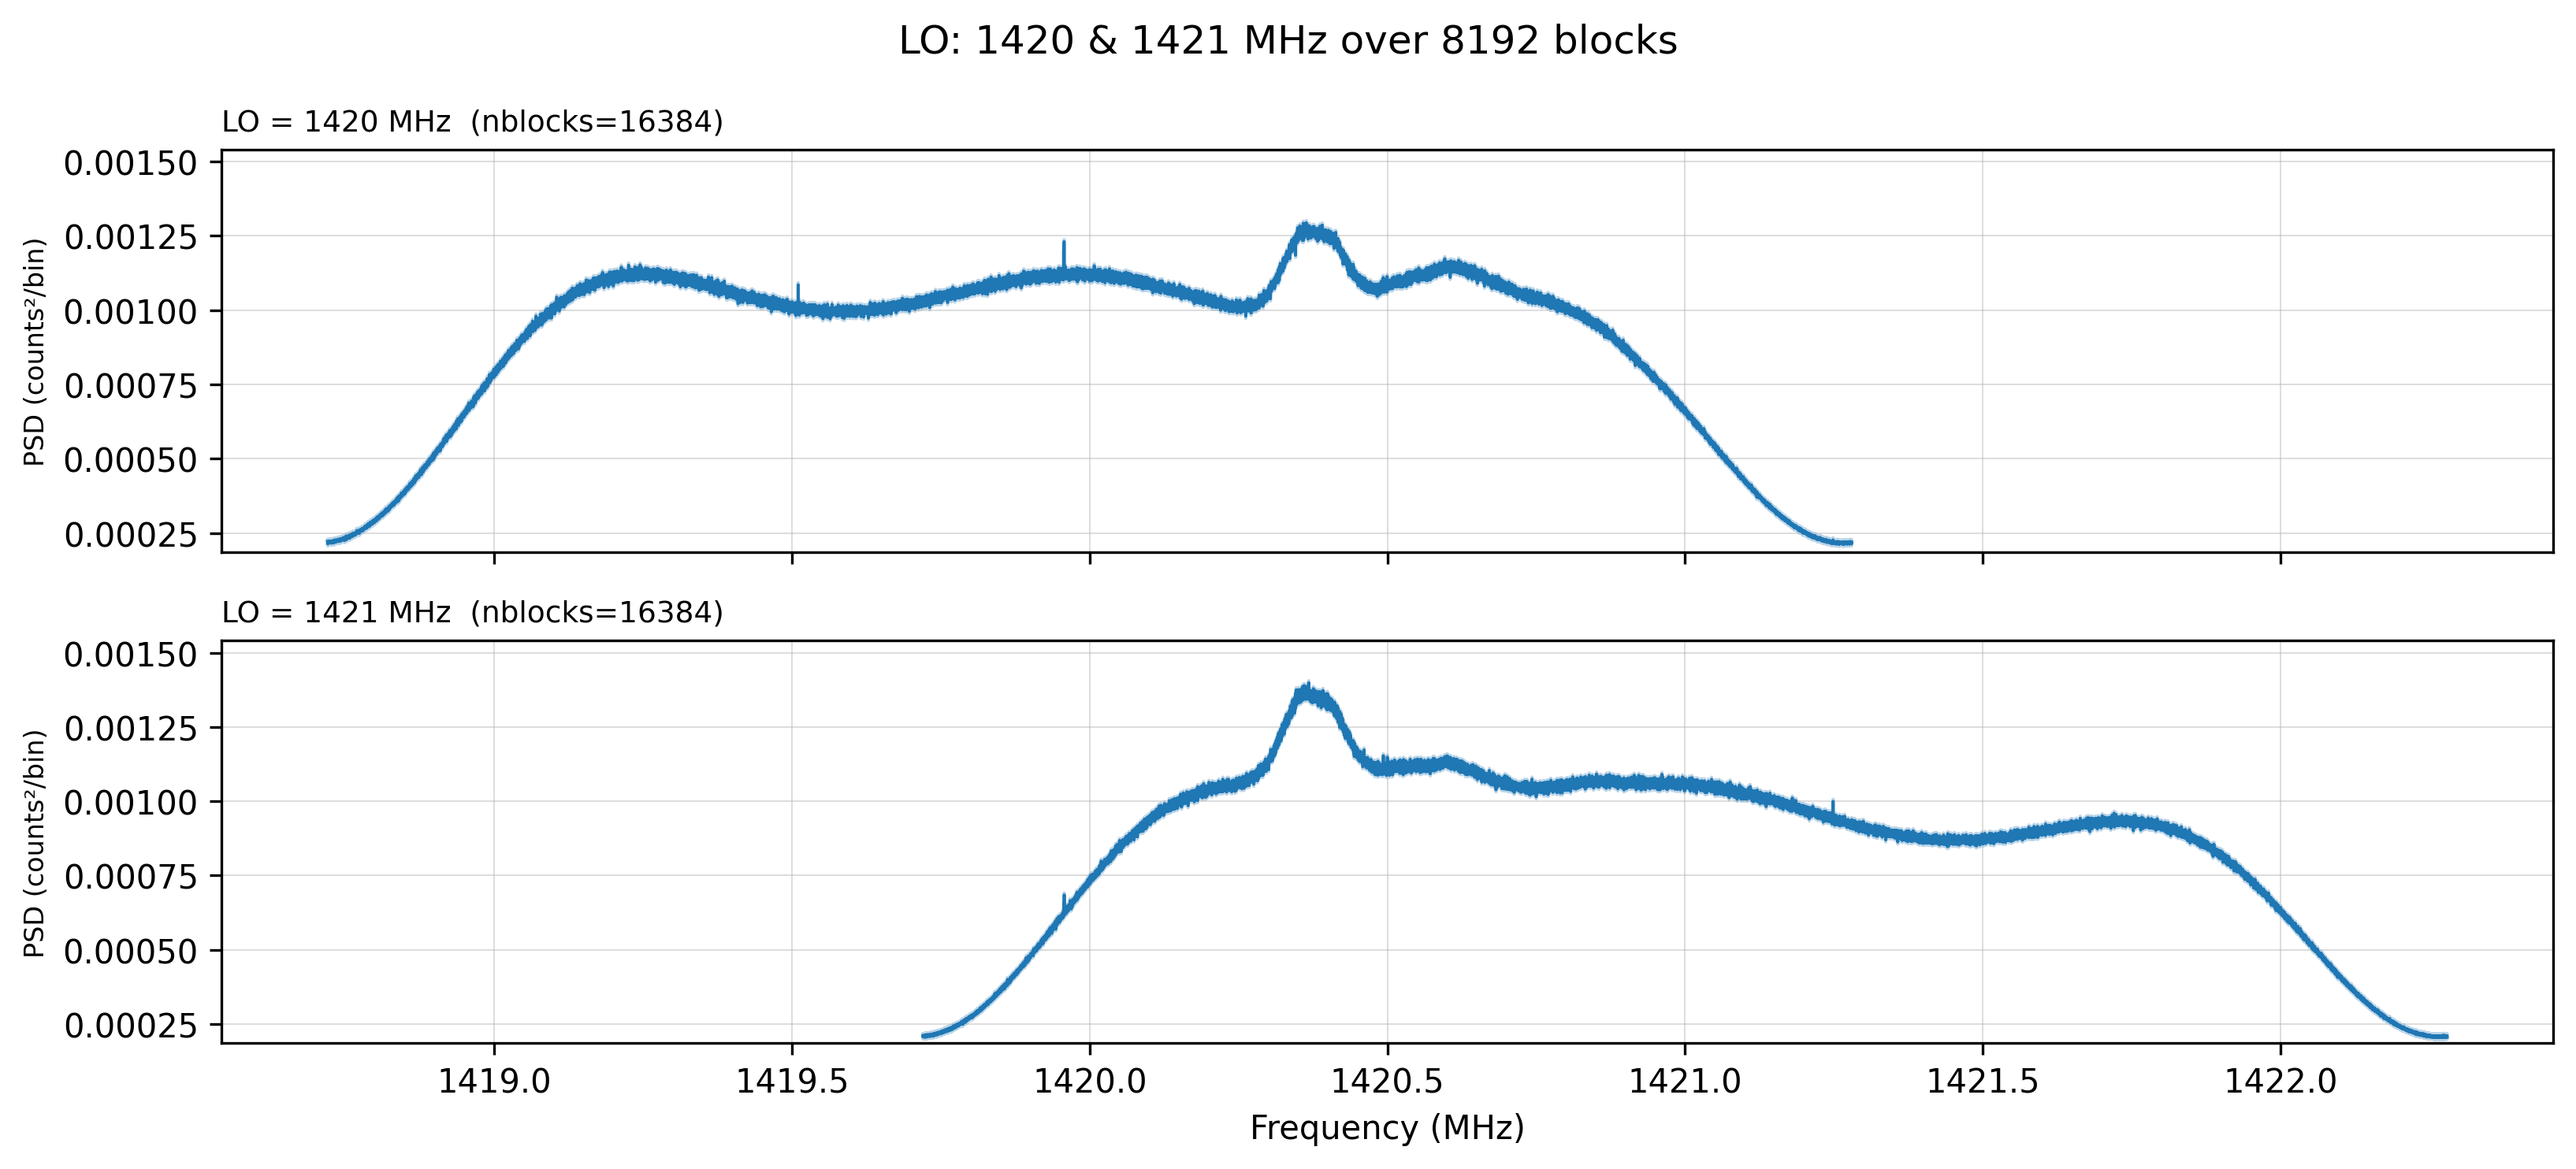

In [9]:
n = len(long_spectra)
fig, axes = plt.subplots(n, 1, figsize=(11, 2.5 * n), dpi=300, sharex=True, sharey=True)

all_psd = [psd_without_dc(spec) for spec in long_spectra]

finite_psd = np.concatenate([p[np.isfinite(p) & (p > 0)] for p in all_psd])
x_all = np.concatenate([spec.freqs_mhz for spec in long_spectra])
x_min, x_max = x_all.min(), x_all.max()
y_min, y_max = finite_psd.min(), finite_psd.max()

x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (np.log10(y_max) - np.log10(y_min))

for ax, spec, psd in zip(axes, long_spectra, all_psd):
    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std, alpha=0.3, color='C0')
    ax.plot(spec.freqs_mhz, psd, lw=0.9, color='C0')
    ax.set_ylabel('PSD (counts²/bin)', fontsize=8)
    ax.set_title(f'LO = {spec.center_freq/1e6:.0f} MHz  (nblocks={spec.nblocks})', fontsize=9, loc='left')
    ax.grid(True, lw=0.4, alpha=0.5)

axes[0].set_xlim(x_min - x_pad, x_max + x_pad)
axes[0].set_ylim(10 ** (np.log10(y_min) - y_pad), 10 ** (np.log10(y_max) + y_pad))
axes[-1].set_xlabel('Frequency (MHz)')
fig.suptitle('LO: 1420 & 1421 MHz over 8192 blocks')
fig.tight_layout()
plt.show()